In [1]:
import pickle
import numpy as np

In [2]:
filtered_metadata=pickle.load(open("../results/filtered_images.pkl","rb"))

In [ ]:
first_image_id=list(filtered_metadata.keys())[0]
first_image=filtered_metadata[first_image_id]
print("First image id: {}".format(first_image_id))
print("First image: {}".format(first_image))

First image id: 20210701_000122_15_2457
First image: {'properties': {'acquired': '2021-07-01T00:01:22.155653Z', 'anomalous_pixels': 0, 'clear_confidence_percent': 54, 'clear_percent': 4, 'cloud_cover': 0.95, 'cloud_percent': 95, 'ground_control': False, 'gsd': 4.1, 'heavy_haze_percent': 1, 'instrument': 'PSB.SD', 'item_type': 'PSScene', 'light_haze_percent': 0, 'pixel_resolution': 3, 'provider': 'planetscope', 'published': '2022-12-09T00:57:07Z', 'publishing_stage': 'finalized', 'quality_category': 'test', 'satellite_azimuth': 284.2, 'satellite_id': '2457', 'shadow_percent': 1, 'snow_ice_percent': 0, 'strip_id': '4652596', 'sun_azimuth': 148.6, 'sun_elevation': 47.4, 'updated': '2022-12-09T00:57:07Z', 'view_angle': 4, 'visible_confidence_percent': 53, 'visible_percent': 5}, 'geometry': {'coordinates': [[[158.51431477894894, 63.006410637363615], [158.37867083907886, 62.82300128172632], [159.05181919110865, 62.71691050158204], [159.1920923902781, 62.9005108532344], [158.51431477894894, 6

In [ ]:
# Count images with at least 1 positive filter result
positive_filter_result_count=0
for image_id in filtered_metadata:
    image_filter_result=filtered_metadata[image_id]['filter_result']
    for filter_name in image_filter_result:
        if image_filter_result[filter_name][0]>0.5 and  filter_name=="forest":
            positive_filter_result_count+=1
            break
print("Positive filter result count: {}".format(positive_filter_result_count))

Positive filter result count: 26153


In [ ]:
# Collect non-zero filter results for each filter
filter_results={}
for image_id in filtered_metadata:
    image_filter_result=filtered_metadata[image_id]['filter_result']
    if image_filter_result['california'][0]==0:
        continue
    for filter_name in image_filter_result:
        if filter_name not in filter_results:
            filter_results[filter_name]=[]
        filter_results[filter_name].append(image_filter_result[filter_name][0])

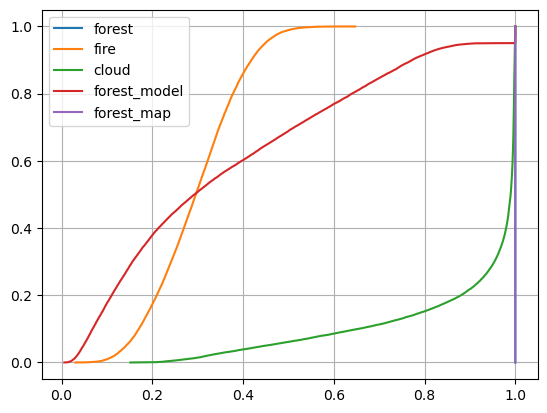

In [ ]:
# Plot cdf for each filter
import matplotlib.pyplot as plt
import numpy as np
for filter_name in filter_results:
    if filter_name in ["root",'port','california','vessel']:
        continue
    filter_result=filter_results[filter_name]
    filter_result=np.array(filter_result)
    filter_result=filter_result[filter_result>0]
    filter_result=np.sort(filter_result)
    plt.plot(filter_result,np.arange(len(filter_result))/len(filter_result),label=filter_name)
plt.legend()
plt.grid()

## How many images are forest/fire?

In [ ]:
forest_count, forest_cloudless_count, fire_count=0,0,0
threshold=0.5
for image_id in filtered_metadata:
    image_filter_result=filtered_metadata[image_id]['filter_result']
    if image_filter_result['forest'][0]>threshold:
        forest_count+=1
        if image_filter_result['cloud'][0]>threshold:
            forest_cloudless_count+=1
            if image_filter_result['fire'][0]>threshold:
                fire_count+=1
print("Forest count: {}".format(forest_count))
print("Forest cloudless count: {}".format(forest_cloudless_count))
print("Fire count: {}".format(fire_count))

Forest count: 26153
Forest cloudless count: 24578
Fire count: 243


In [ ]:
#misclassification
forest_count, forest_cloudless_count, fire_count=0,0,0
threshold=0.5
for image_id in filtered_metadata:
    image_filter_result=filtered_metadata[image_id]['filter_result']
    if image_filter_result['forest_model'][0]>threshold:
        forest_count+=1
        if image_filter_result['fire'][0]>threshold:
            fire_count+=1
print("Forest count: {}".format(forest_count))
print("Forest cloudless count: {}".format(forest_cloudless_count))
print("Fire count: {}".format(fire_count))

### How many images are ports?

In [ ]:
port_count, port_cloudless_count=0,0
threshold=0.5
for image_id in filtered_metadata:
    image_filter_result=filtered_metadata[image_id]['filter_result']
    if image_filter_result['port'][0]>threshold:
        port_count+=1
        if image_filter_result['cloud'][0]>threshold:
            port_cloudless_count+=1
print("Port count: {}".format(port_count))
print("Port cloudless count: {}".format(port_cloudless_count))

Port count: 2642
Port cloudless count: 1769


### Which satellite takes the most fire images?

In [ ]:
fire_images=[]
for image_id in filtered_metadata:
    if filtered_metadata[image_id]['filter_result']['fire'][0]>0.5:
        fire_images.append(image_id)

In [ ]:
sats=[x[-4:] for x in fire_images]

### How accurate is weather forecast?

In [ ]:
x,y=[],[]
for image_id in filtered_metadata:
    if filtered_metadata[image_id]['filter_result']['california'][0] < 0.5:
        continue
    x.append(filtered_metadata[image_id]['filter_result']['cloud'][0])
    y.append(filtered_metadata[image_id]['side_channel']['cloud'])

Text(0, 0.5, 'Cloud side channel')

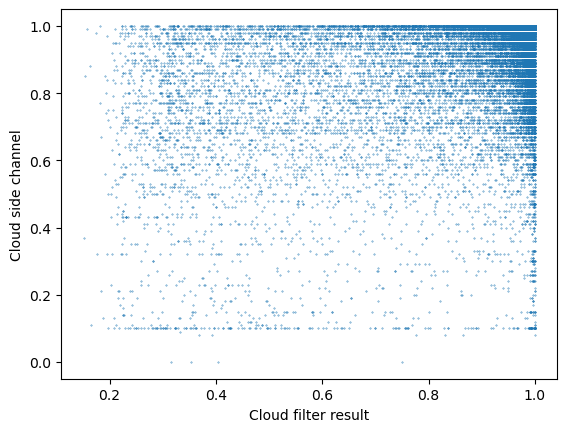

In [ ]:
plt.scatter(x,y, s=.1)
plt.xlabel("Cloud filter result")
plt.ylabel("Cloud side channel")

In [ ]:
# Simulate classification here for all images
x,y=[],[]
for image_id in filtered_metadata:
    if filtered_metadata[image_id]['filter_result']['california'][0] < 0.5 and filtered_metadata[image_id]['filter_result']['port'][0] < 0.5:
        continue
    x.append(filtered_metadata[image_id]['filter_result']['cloud'][0])
    y.append(filtered_metadata[image_id]['side_channel']['cloud'])
fp,fn,tp,tn=0,0,0,0
computed=0
for x0, y0 in zip(x,y):
    if 0.2<y0<0.8:
        if x0>0.5:
            tp+=1
        else:
            tn+=1
        computed+=1
        continue
    if y0<0.2: # classified as negative
        if x0>0.5:
            fn+=1
        else:
            tn+=1
    else: # classified as positive
        if x0>0.5:
            tp+=1
        else:
            fp+=1
print("TP: {}, TN: {}, FP: {}, FN: {}".format(tp,tn,fp,fn))
print("Accuracy: {}".format((tp+tn)/(tp+tn+fp+fn)))
print("Precision: {}".format(tp/(tp+fp)))
print("Recall: {}".format(tp/(tp+fn)))
print("F1: {}".format(2*tp/(2*tp+fp+fn)))
print("Proportion of computed: {}".format(computed/len(x)))

TP: 36623, TN: 1919, FP: 1245, FN: 226
Accuracy: 0.9632369479919026
Precision: 0.9671226365268829
Recall: 0.9938668620586719
F1: 0.9803123787089952
Proportion of computed: 0.16347187164171645


In [ ]:
# Create a confusion matrix
confusion_matrix=np.zeros((2,3))
for x0,y0 in zip(x,y):
    if 0.2<y0<0.8:
        if x0>0.5:
            confusion_matrix[1,1]+=1
        else:
            confusion_matrix[0,1]+=1
    elif y0<=0.2:
        if x0>0.5:
            confusion_matrix[1,0]+=1
        else:
            confusion_matrix[0,0]+=1
    else:
        if x0>0.5:
            confusion_matrix[1,2]+=1
        else:
            confusion_matrix[0,2]+=1
print(confusion_matrix)

[[  251.  1668.  1245.]
 [  226.  4873. 31750.]]
